In [96]:
import sys
import os
from datetime import datetime
import numpy as np
import pandas as pd
import spacy
import emoji
from gensim.models import Word2Vec
import torch
from torch import optim
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

## Data Preporcessing

In [2]:
## try bidirectioanl
## smaller batch size
## smaller lr
## rmsprop
## dropout
## resize hidden size or embedding dim

In [2]:
train_x = pd.read_csv("data/train_x.csv")
train_y = pd.read_csv("data/train_y.csv")
test_x = pd.read_csv("data/test_x.csv")

In [165]:
def dataPreprocess(comments):
    ret = comments.copy()
    nlp = spacy.load("en_core_web_sm")
    for i in range(len(ret)):
        if i % 1000 == 999:
            print(f'No. {i+1}')
        
        doc = nlp(ret[i])
        # tolower, lemmatization, remove @user and non-alpha
#         ret[i] = [x.lemma_.strip().lower() for x in doc if (x not in emoji.UNICODE_EMOJI) and x.text[0].isalpha() and x.text.strip()]
#         ret[i] = [x.text.strip().lower() for x in doc if (x not in emoji.UNICODE_EMOJI) and not x.is_stop and x.text[0].isalpha() and x.text.strip()]
        ret[i] = [x.text.lower() for x in doc if not x.is_stop and x.text[0].isalpha()]
#         ret[i] = ret[i].split()
        
    return ret

def trainValidSplit(x, y, ratio):
    assert len(x) == len(y)
    n = int(len(x) * ratio)
    return x[:n], y[:n], x[n:], y[n:]

In [5]:
# print(train_x.comment[3122])
# print(all_comments[3122])

In [26]:
##################### Read Data ############################

train_comments_tmp = dataPreprocess(train_x.comment).tolist()
train_labels_tmp = train_y.label.tolist()

# remove all empty comments in train data
train_comments = []
train_labels = []
for i in range(len(train_comments_tmp)):
    if len(train_comments_tmp[i]) != 0:
        train_comments.append(train_comments_tmp[i])
        train_labels.append(train_labels_tmp[i])

test_comments = dataPreprocess(test_x.comment).tolist()
all_comments = train_comments + test_comments

No. 1000
No. 2000
No. 3000
No. 4000
No. 5000
No. 6000
No. 7000
No. 8000
No. 9000
No. 10000
No. 11000
No. 12000
No. 13000


In [5]:
##################### Define Dataset and model classes ##################

class hw5_dataset(Dataset):
    def __init__(self, is_training, dataX, dataY, w2v):
        self.is_training = is_training
        self.dataX = dataX
        self.dataY = dataY
        self.w2v = w2v # word2vec model
        
    def __len__(self):
        return len(self.dataX)
    
    def __getitem__(self, idx):
        x = [self.w2v.wv[x] for x in self.dataX[idx]]
        if not self.is_training:
            return x
        y = self.dataY[idx]
        return x, y

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    xx = [torch.tensor(x) for x in xx]
    yy = torch.tensor(yy)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    return xx_pad, yy

def pad_collate_test(batch):
    batch = [torch.tensor(x) for x in batch]
    xx_pad = pad_sequence(batch, batch_first=True, padding_value=0)
    return xx_pad

class RNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size=128, num_layers=1, dropout=0, bidirectional=False):
        super(RNN_LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, 
                            num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        
        self.fc1 = nn.Sequential(
            nn.Linear(hidden_size*(2 if bidirectional else 1), 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32)
        )
        self.fc2 = nn.Linear(32, 2)
        
        # orthogonal init lstm parameters
        for param in self.lstm.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        return out
        

In [6]:
##################### Train word2vec model #########################

embedding_dim = 200
model_path = f'models/myword2vec_nospacy_{embedding_dim}.model'
if os.path.exists(model_path):
    myw2v = Word2Vec.load(model_path)
else:
    myw2v = Word2Vec(all_comments, min_count = 1, size = embedding_dim)
    myw2v.train(all_comments, total_examples = myw2v.corpus_count, epochs = 300)
    myw2v.save(model_path)

In [8]:
##################### Create Datasets and DataLoaders ################

################ for validation ###########
from sklearn.model_selection import train_test_split
trainX, validX, trainY, validY = train_test_split(train_comments, train_labels, test_size=0.1, random_state=42)
train_data = hw5_dataset(True, trainX, trainY, myw2v)
valid_data = hw5_dataset(True, validX, validY, myw2v)
###########################################

################ final train ##############
# train_data = hw5_dataset(True, train_comments, train_labels, myw2v)
###########################################


batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

## Start Training
### training log:
- valid loss: 0.57   acc: 0.73   (original)
- valid loss: 0.55   acc: 0.75   (add init lstm)
- valid loss: 0.5362 acc: 0.7522 (two lstm, dropout=0.2) (0.8 又更好) (n_layers = 3 更好)
- valid loss: 0.5382 acc: 0.7468 (bidirectional=True)
- valid loss: 0.6129 acc: 0.7409 (lr=1e-4, 17epoch, 3 lstm, bidirectional, dropout0.8, init lstm)
- Epoch: 009, valid loss: 0.5632, valid acc: 0.7511 (5e-4, n=3, b, d=0.8, emb=250, hid=128)
- Epoch: 007, valid loss: 0.5385, valid acc: 0.7405
- hidden size 64: worse
- emb = 200: Epoch: 007, valid loss: 0.5779, valid acc: 0.7558
- emb = 150, hidden = 96 => Epoch: 011, valid loss: 0.5419, valid acc: 0.7587
- dropout to 0.5 => Epoch: 007, valid loss: 0.6289, valid acc: 0.7556
- bi = False, dp = 0.8, emb = 200, hid = 150 => Epoch: 007, valid loss: 0.5426, valid acc: 0.7493
- hid = 96, test_size = 0.1 => Epoch: 006, valid loss: 0.5157, valid acc: 0.7619

## 正在嘗試bi = False

In [9]:
lr = 5e-4
epochs = 50
hidden_size = 96
bd = False
n_l = 3
dp = 0.8

In [10]:
model = RNN_LSTM(embedding_dim, hidden_size=hidden_size, bidirectional=bd, num_layers=n_l, dropout=dp)
# model.apply(weight_init)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()

history = {'val_loss': [], 'val_acc': [], 'train_loss': [], 'train_acc': []}
for epoch in range(epochs):
    model.train()
    train_loss = []
    train_acc = []
    for comments, labels in train_loader:
        if use_gpu:
            comments = comments.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(comments)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        predict = torch.max(outputs, 1)[1]
        acc = np.mean((labels == predict).cpu().numpy())
        train_acc.append(acc)
        train_loss.append(loss.item())
        
#     if epoch % 10 == 0:
    train_loss = np.mean(train_loss)
    train_acc = np.mean(train_acc)
    print(f'Epoch: {"%03d" % (epoch)}, train loss: {"%.4f" % train_loss}, train acc: {"%.4f" % train_acc}')
    torch.save(model.state_dict(), f'models/rnn_epoch{epoch}_{datetime.now().strftime("%m%d%H%M")}')

    # validation
    model.eval()
    with torch.no_grad():
        valid_loss = []
        valid_acc = []
        for comments, labels in valid_loader:
            if use_gpu:
                comments = comments.cuda()
                labels = labels.cuda()
            outputs = model(comments)
            loss = loss_fn(outputs, labels)
            predict = torch.max(outputs, 1)[1]
#             print(predict)
            acc = np.mean((labels == predict).cpu().numpy())
            valid_acc.append(acc)
            valid_loss.append(loss.item())
        valid_loss = np.mean(valid_loss)
        valid_acc = np.mean(valid_acc)
        print(f'Epoch: {"%03d" % (epoch)}, valid loss: {"%.4f" % valid_loss}, valid acc: {"%.4f" % valid_acc}')

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)        
        history['val_loss'].append(valid_loss)
        history['val_acc'].append(valid_acc)


Epoch: 000, train loss: 0.7010, train acc: 0.5282
Epoch: 000, valid loss: 0.6428, valid acc: 0.6767
Epoch: 001, train loss: 0.6452, train acc: 0.6634
Epoch: 001, valid loss: 0.6292, valid acc: 0.6767
Epoch: 002, train loss: 0.6396, train acc: 0.6670
Epoch: 002, valid loss: 0.6292, valid acc: 0.6767
Epoch: 003, train loss: 0.6390, train acc: 0.6671
Epoch: 003, valid loss: 0.6259, valid acc: 0.6767
Epoch: 004, train loss: 0.6296, train acc: 0.6671
Epoch: 004, valid loss: 0.6226, valid acc: 0.6782
Epoch: 005, train loss: 0.5907, train acc: 0.6971
Epoch: 005, valid loss: 0.6422, valid acc: 0.6430
Epoch: 006, train loss: 0.5374, train acc: 0.7418
Epoch: 006, valid loss: 0.5594, valid acc: 0.7347
Epoch: 007, train loss: 0.4957, train acc: 0.7704
Epoch: 007, valid loss: 0.5507, valid acc: 0.7332
Epoch: 008, train loss: 0.4599, train acc: 0.7975
Epoch: 008, valid loss: 0.5903, valid acc: 0.7417
Epoch: 009, train loss: 0.4205, train acc: 0.8228
Epoch: 009, valid loss: 0.5790, valid acc: 0.7422


KeyboardInterrupt: 

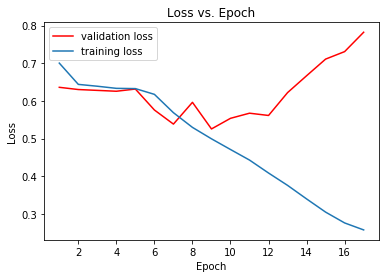

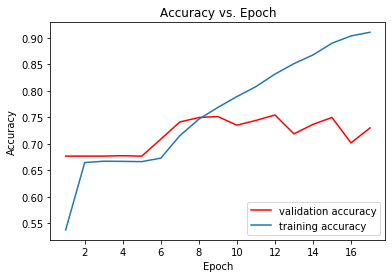

In [50]:
def plot_history(history):
    import matplotlib.pyplot as plt

    epoch = len(history['train_acc'])
    x = list(range(1, epoch+1))
    # plot loss
    plt.plot(x, history['val_loss'], color='red', label='validation loss')
    plt.plot(x, history['train_loss'], label='training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()
    plt.cla()
    # plot acc
    plt.plot(x, history['val_acc'], color='red', label='validation accuracy')
    plt.plot(x, history['train_acc'], label='training accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend(loc='lower right')
    plt.show()
#     plt.cla()
    
plot_history(history)

## Testing!

In [11]:
# if test comment is empty, set it equal to it's previous
for i in range(len(test_comments)):
    if len(test_comments[i]) == 0:
        test_comments[i-1] = test_comments[i]

test_data = hw5_dataset(False, test_comments, None, myw2v)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_test)

model = RNN_LSTM(embedding_dim, hidden_size=hidden_size, bidirectional=bd, num_layers=n_l, dropout=dp)
model.load_state_dict(torch.load('models/rnn_epoch7_12130452'))
use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()

model.eval()
results = []
with torch.no_grad():
    for comments in test_loader:
        if use_gpu:
            comments = comments.cuda()
        outputs = model(comments)
        predict = torch.max(outputs, 1)[1]
        results += predict.cpu().tolist()

In [12]:
def write_ans(result, path):
    print(f'Writing results to {path}')
    dirname = os.path.dirname(path)
    if dirname and not os.path.exists(dirname):
        os.makedirs(dirname)
        
    df = pd.DataFrame({'id': np.arange(0, len(result)), 'label': result})
    df.to_csv(path, index=False)
write_ans(results, 'results/tmp.csv')

Writing results to results/tmp.csv


## BOW + DNN

In [27]:
from collections import Counter

In [28]:
vocab = Counter()
for comment in all_comments:
    vocab.update(comment)

In [50]:
def word_to_vector(word):
    global word_id_map
    v = np.zeros(len(word_id_map))
    v[word_id_map[word]] = 1
    return v

def sentences_to_vectors(train_comments):
    vectors = []
    for comment in train_comments:
        sentence_vector = np.array([word_to_vector(word) for word in comment]).sum(axis=0)
        vectors.append(sentence_vector.tolist())
    return np.array(vectors)
        
word_id_map = {x: i for i, x in enumerate(list(vocab.keys()))}
train_vectors = sentences_to_vectors(train_comments)
trainX, validX, trainY, validY = train_test_split(train_vectors, train_labels, test_size=0.2, random_state=42)

In [89]:
batch_size = 64
train_loader = DataLoader(list(zip(trainX, trainY)), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(list(zip(validX, validY)), batch_size=batch_size, shuffle=False)

### Define DNN

In [94]:
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 2),
            nn.BatchNorm1d(2),
            nn.LeakyReLU(),
        )
        
    def forward(self, x):
        out = self.fc(x)
        return out

## Training

In [106]:
lr = 5e-4
epochs = 20

model = DNN(len(word_id_map))
# model.apply(weight_init)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()

history = {'val_loss': [], 'val_acc': [], 'train_loss': [], 'train_acc': []}
for epoch in range(epochs):
    model.train()
    train_loss = []
    train_acc = []
    for comments, labels in train_loader:
#         print(comments)
#         print(labels)
#         sys.exit(0)
        if use_gpu:
            comments = comments.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(comments.float())
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        predict = torch.max(outputs, 1)[1]
        acc = np.mean((labels == predict).cpu().numpy())
        train_acc.append(acc)
        train_loss.append(loss.item())
        
#     if epoch % 10 == 0:
    train_loss = np.mean(train_loss)
    train_acc = np.mean(train_acc)
    print(f'Epoch: {"%03d" % (epoch)}, train loss: {"%.4f" % train_loss}, train acc: {"%.4f" % train_acc}')
    torch.save(model.state_dict(), f'models/dnn_epoch{epoch}_{datetime.now().strftime("%m%d%H%M")}')

    # validation
    model.eval()
    with torch.no_grad():
        valid_loss = []
        valid_acc = []
        for comments, labels in valid_loader:
            if use_gpu:
                comments = comments.cuda()
                labels = labels.cuda()
            outputs = model(comments.float())
            loss = loss_fn(outputs, labels)
            predict = torch.max(outputs, 1)[1]
#             print(predict)
            acc = np.mean((labels == predict).cpu().numpy())
            valid_acc.append(acc)
            valid_loss.append(loss.item())
        valid_loss = np.mean(valid_loss)
        valid_acc = np.mean(valid_acc)
        print(f'Epoch: {"%03d" % (epoch)}, valid loss: {"%.4f" % valid_loss}, valid acc: {"%.4f" % valid_acc}')

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)        
        history['val_loss'].append(valid_loss)
        history['val_acc'].append(valid_acc)


Epoch: 000, train loss: 0.6113, train acc: 0.6700
Epoch: 000, valid loss: 0.5507, valid acc: 0.7145
Epoch: 001, train loss: 0.4314, train acc: 0.8427
Epoch: 001, valid loss: 0.5492, valid acc: 0.7050
Epoch: 002, train loss: 0.3481, train acc: 0.9047
Epoch: 002, valid loss: 0.5401, valid acc: 0.7351
Epoch: 003, train loss: 0.2891, train acc: 0.9356
Epoch: 003, valid loss: 0.5457, valid acc: 0.7360
Epoch: 004, train loss: 0.2488, train acc: 0.9575
Epoch: 004, valid loss: 0.5423, valid acc: 0.7391
Epoch: 005, train loss: 0.2190, train acc: 0.9688
Epoch: 005, valid loss: 0.5492, valid acc: 0.7352
Epoch: 006, train loss: 0.1914, train acc: 0.9797
Epoch: 006, valid loss: 0.5472, valid acc: 0.7438
Epoch: 007, train loss: 0.1684, train acc: 0.9841
Epoch: 007, valid loss: 0.5656, valid acc: 0.7369
Epoch: 008, train loss: 0.1502, train acc: 0.9883
Epoch: 008, valid loss: 0.5658, valid acc: 0.7395
Epoch: 009, train loss: 0.1371, train acc: 0.9884
Epoch: 009, valid loss: 0.5893, valid acc: 0.7335


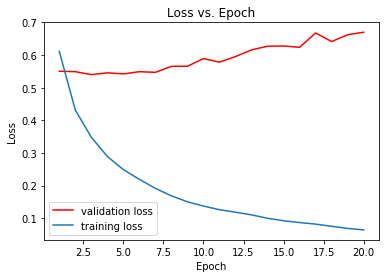

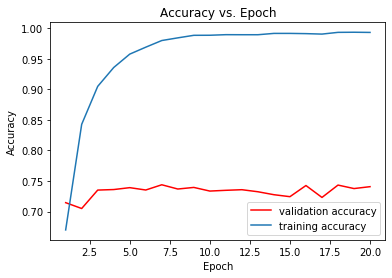

In [107]:
def plot_history(history):
    import matplotlib.pyplot as plt

    epoch = len(history['train_acc'])
    x = list(range(1, epoch+1))
    # plot loss
    plt.plot(x, history['val_loss'], color='red', label='validation loss')
    plt.plot(x, history['train_loss'], label='training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()
    plt.cla()
    # plot acc
    plt.plot(x, history['val_acc'], color='red', label='validation accuracy')
    plt.plot(x, history['train_acc'], label='training accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

## Testing

In [159]:
test_x

,id,comment
0,Today is hot,but I am happy.
1,I am happy,but today is hot.


In [166]:
test_x = pd.read_csv("playground/today.csv")
test_comments = dataPreprocess(test_x.comment).tolist()

# if test comment is empty, set it equal to it's previous
for i in range(len(test_comments)):
    if len(test_comments[i]) == 0:
        test_comments[i] = test_comments[i-1]

test_vectors = sentences_to_vectors(test_comments)
test_loader = DataLoader(test_vectors, batch_size=batch_size, shuffle=False)

model = DNN(len(word_id_map))
model.load_state_dict(torch.load('models/dnn_epoch17_12130724'))
use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()

model.eval()
results = []
with torch.no_grad():
    for comments in test_loader:
        if use_gpu:
            comments = comments.cuda()
        outputs = model(comments.float())
        print(outputs)
        predict = torch.max(outputs, 1)[1]
        results += predict.cpu().tolist()
        
# write_ans(results, 'results/tmp.csv')

tensor([[ 2.3022, -0.0030],
        [ 2.3022, -0.0030]], device='cuda:0')


In [168]:
def softmax(x):
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

# print("BOW: \n", softmax(np.array([[1.8339e+00, -1.2462e-03], [2.7255e+00, -5.3395e-03]])))
print("RNN (Today is hot, but I am happy.): \n", softmax(np.array([0.6033, -0.4029])))
print("RNN (I am happy, but today is hot.): \n", softmax(np.array([0.4545, -0.4530])))
print("BOW (Today is hot, but I am happy.): \n", softmax(np.array([ 2.3022, -0.0030])))
print("BOW (I am happy, but today is hot.): \n", softmax(np.array([ 2.3022, -0.0030])))

RNN (Today is hot, but I am happy.): 
 [0.73227582 0.26772418]
RNN (I am happy, but today is hot.): 
 [0.71248831 0.28751169]
BOW (Today is hot, but I am happy.): 
 [0.90930679 0.09069321]
BOW (I am happy, but today is hot.): 
 [0.90930679 0.09069321]
